In [1]:
# array processing
import numpy as np

# image processing
import matplotlib.pyplot as plt
import cv2
import imgaug as ia
import imgaug.augmenters as iaa

# ml
import tensorflow
from tensorflow import keras

# prog bar
from tqdm.notebook import tqdm

In [2]:
class ShapeData(keras.utils.Sequence): # defined to be tf-compatible but can be easily adapted for other frameworks
    
    def __init__(self, 
                 dim,                 # dimensions of the image, images will be of shape (dim, dim, 3)
                 batch_size,          # number of images per batch
                 chance_same=0.5,     # probability of generating two images with the same set of objects
                 max_shapes=5,        # maximum number of shapes. true number of shapes selected from [1, max_shapes]
                 width_factor=10,     # side lengths/diameters of shapes will be round(dim/width_factor)
                 rotate=True,         # whether or not to rotate the image
                 rot_deg=20,          # if rotate, how many degrees to rotate. degree rotation selected from [-rot_deg/2, rot_deg/2]
                 padding=0.2,         # proportion of image margins to exclude from shapes being placed, [0, 1]. this is recommended
                                      #     rotation to prevent shapes from getting chopped off
                 shape_outline=True,  # ignore this I tried to make it work but it didn't
                 colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)], # set of possible colors (default: RGB)
                 length=64            # technical thing for tf datasets, specifies number of batches in an epoch
                ):
        
        self.dim = dim
        self.operative_dim = round(dim * (1 - padding))
        self.batch_size = batch_size
        self.chance_same = chance_same
        self.max_shapes = max_shapes
        self.colors = colors
        self.width_factor = width_factor
        self.padding = padding
        self.rotate = rotate
        self.shape_outline = shape_outline
        self.len = length
        if self.rotate:
            self.aug_seq = iaa.Sequential([iaa.Affine(rotate=(-int(rot_deg/2), int(rot_deg/2)))])
        
    def placeCircle(self, img, color, fillstat=-1): # internal function
        radius = round(self.dim/(self.width_factor*2))
        pos = (np.random.randint(radius, self.operative_dim-radius), np.random.randint(radius, self.operative_dim-radius))
        return cv2.circle(img,
                          pos,
                          color=color,
                          thickness=fillstat,
                          radius=radius)
    
    def placeSquare(self, img, color, fillstat=-1): # internal function
        length = round(self.operative_dim/self.width_factor)
        pos = (np.random.randint(0, self.operative_dim-length), np.random.randint(0, self.operative_dim-length))
        return cv2.rectangle(img,
                             pos,
                             (pos[0]+length, pos[1]+length),
                             color=color,
                             thickness=fillstat)
    
    def placeTriangle(self, img, color, fillstat=-1, buffer_prop=0.2): # internal function
        buffer = round(self.operative_dim * buffer_prop) # cheap trick because I hate triangles in cv2
        length = int(round(self.dim/self.width_factor))
        left_pos = (int(np.random.randint(buffer, self.operative_dim-length-buffer)), int(np.random.randint(length, self.operative_dim-buffer)))
        right_pos = (left_pos[0], left_pos[1]+length)
        top_pos = (int(left_pos[0] - np.sqrt(3)*(length/2)), int(left_pos[1]+length/2))
        tri_pos = np.array([left_pos, right_pos, top_pos])
        cv2.drawContours(img, [tri_pos], 0, color, fillstat)
        return img
    
    def genShapeSet(self): # internal function
        choices = [self.placeCircle, self.placeSquare, self.placeTriangle]
        return [np.random.choice(choices) for i in range(np.random.randint(1, self.max_shapes+1))]
    
    def __len__(self): # returns length of dataset
        return self.len
        
    def __getitem__(self, index): # generates a set of data and returns in form (x1, x2), y
        batch_canvas_1 = np.zeros((self.batch_size, self.operative_dim, self.operative_dim, 3))
        batch_canvas_2 = np.zeros((self.batch_size, self.operative_dim, self.operative_dim, 3))
        labels = []
        for batch in range(self.batch_size): # generate batches
            
            labels.append(np.random.choice([0, 1]))
            shapeSet = self.genShapeSet()
            colors = [self.colors[np.random.randint(len(self.colors))] for shape in shapeSet]
            for color, shapeConst in zip(colors, shapeSet):
                batch_canvas_1[batch,:,:,:] = shapeConst(batch_canvas_1[batch,:,:,:], color)
#                 if self.shape_outline: # ignore this
#                     batch_canvas_1[batch,:,:,:] = shapeConst(batch_canvas_1[batch,:,:,:], color=0, fillstat=2)
            if not labels[-1]: # if label is 0, generate new shape set as second group
                shapeSet = self.genShapeSet()
                colors = [self.colors[np.random.randint(len(self.colors))] for shape in shapeSet]
            for color, shapeConst in zip(colors, shapeSet):
                batch_canvas_2[batch,:,:,:] = shapeConst(batch_canvas_2[batch,:,:,:], color)
#                 if self.shape_outline: # ignore this
#                     batch_canvas_2[batch,:,:,:] = shapeConst(batch_canvas_2[batch,:,:,:], color=0, fillstat=2)
                
        if self.operative_dim != self.dim: # enact padding
            temp_canvas_1, temp_canvas_2 = batch_canvas_1, batch_canvas_2
            batch_canvas_1 = np.zeros((self.batch_size, self.dim, self.dim, 3))
            batch_canvas_2 = np.zeros((self.batch_size, self.dim, self.dim, 3))
            min_start = int(np.round((self.dim - self.operative_dim)/2))
            batch_canvas_1[:, min_start:min_start+self.operative_dim, min_start:min_start+self.operative_dim, :] = temp_canvas_1
            batch_canvas_2[:, min_start:min_start+self.operative_dim, min_start:min_start+self.operative_dim, :] = temp_canvas_2
        if self.rotate: # enact rotation
            batch_canvas_1 = self.aug_seq(images=batch_canvas_1)
            batch_canvas_2 = self.aug_seq(images=batch_canvas_2)
            
        return (batch_canvas_1, batch_canvas_2), labels

In [3]:
def show_off_dataset(data, NUM_BATCHES_TO_SHOW=1, BATCH_SIZE=16):
    for batch_ind in tqdm(range(NUM_BATCHES_TO_SHOW)):
        batch_canvases, labels = data.__getitem__(batch_ind)
        bc1, bc2 = batch_canvases
        for batch in range(BATCH_SIZE):
            fig = plt.figure(figsize=(10, 5), dpi=400)
            fig.suptitle(labels[batch])
            plt.subplot(1, 2, 1)
            plt.imshow(bc1[batch])
            plt.axis('off')
            plt.subplot(1, 2, 2)
            plt.imshow(bc2[batch])
            plt.axis('off')
            plt.show()
            plt.close()

  0%|          | 0/1 [00:00<?, ?it/s]

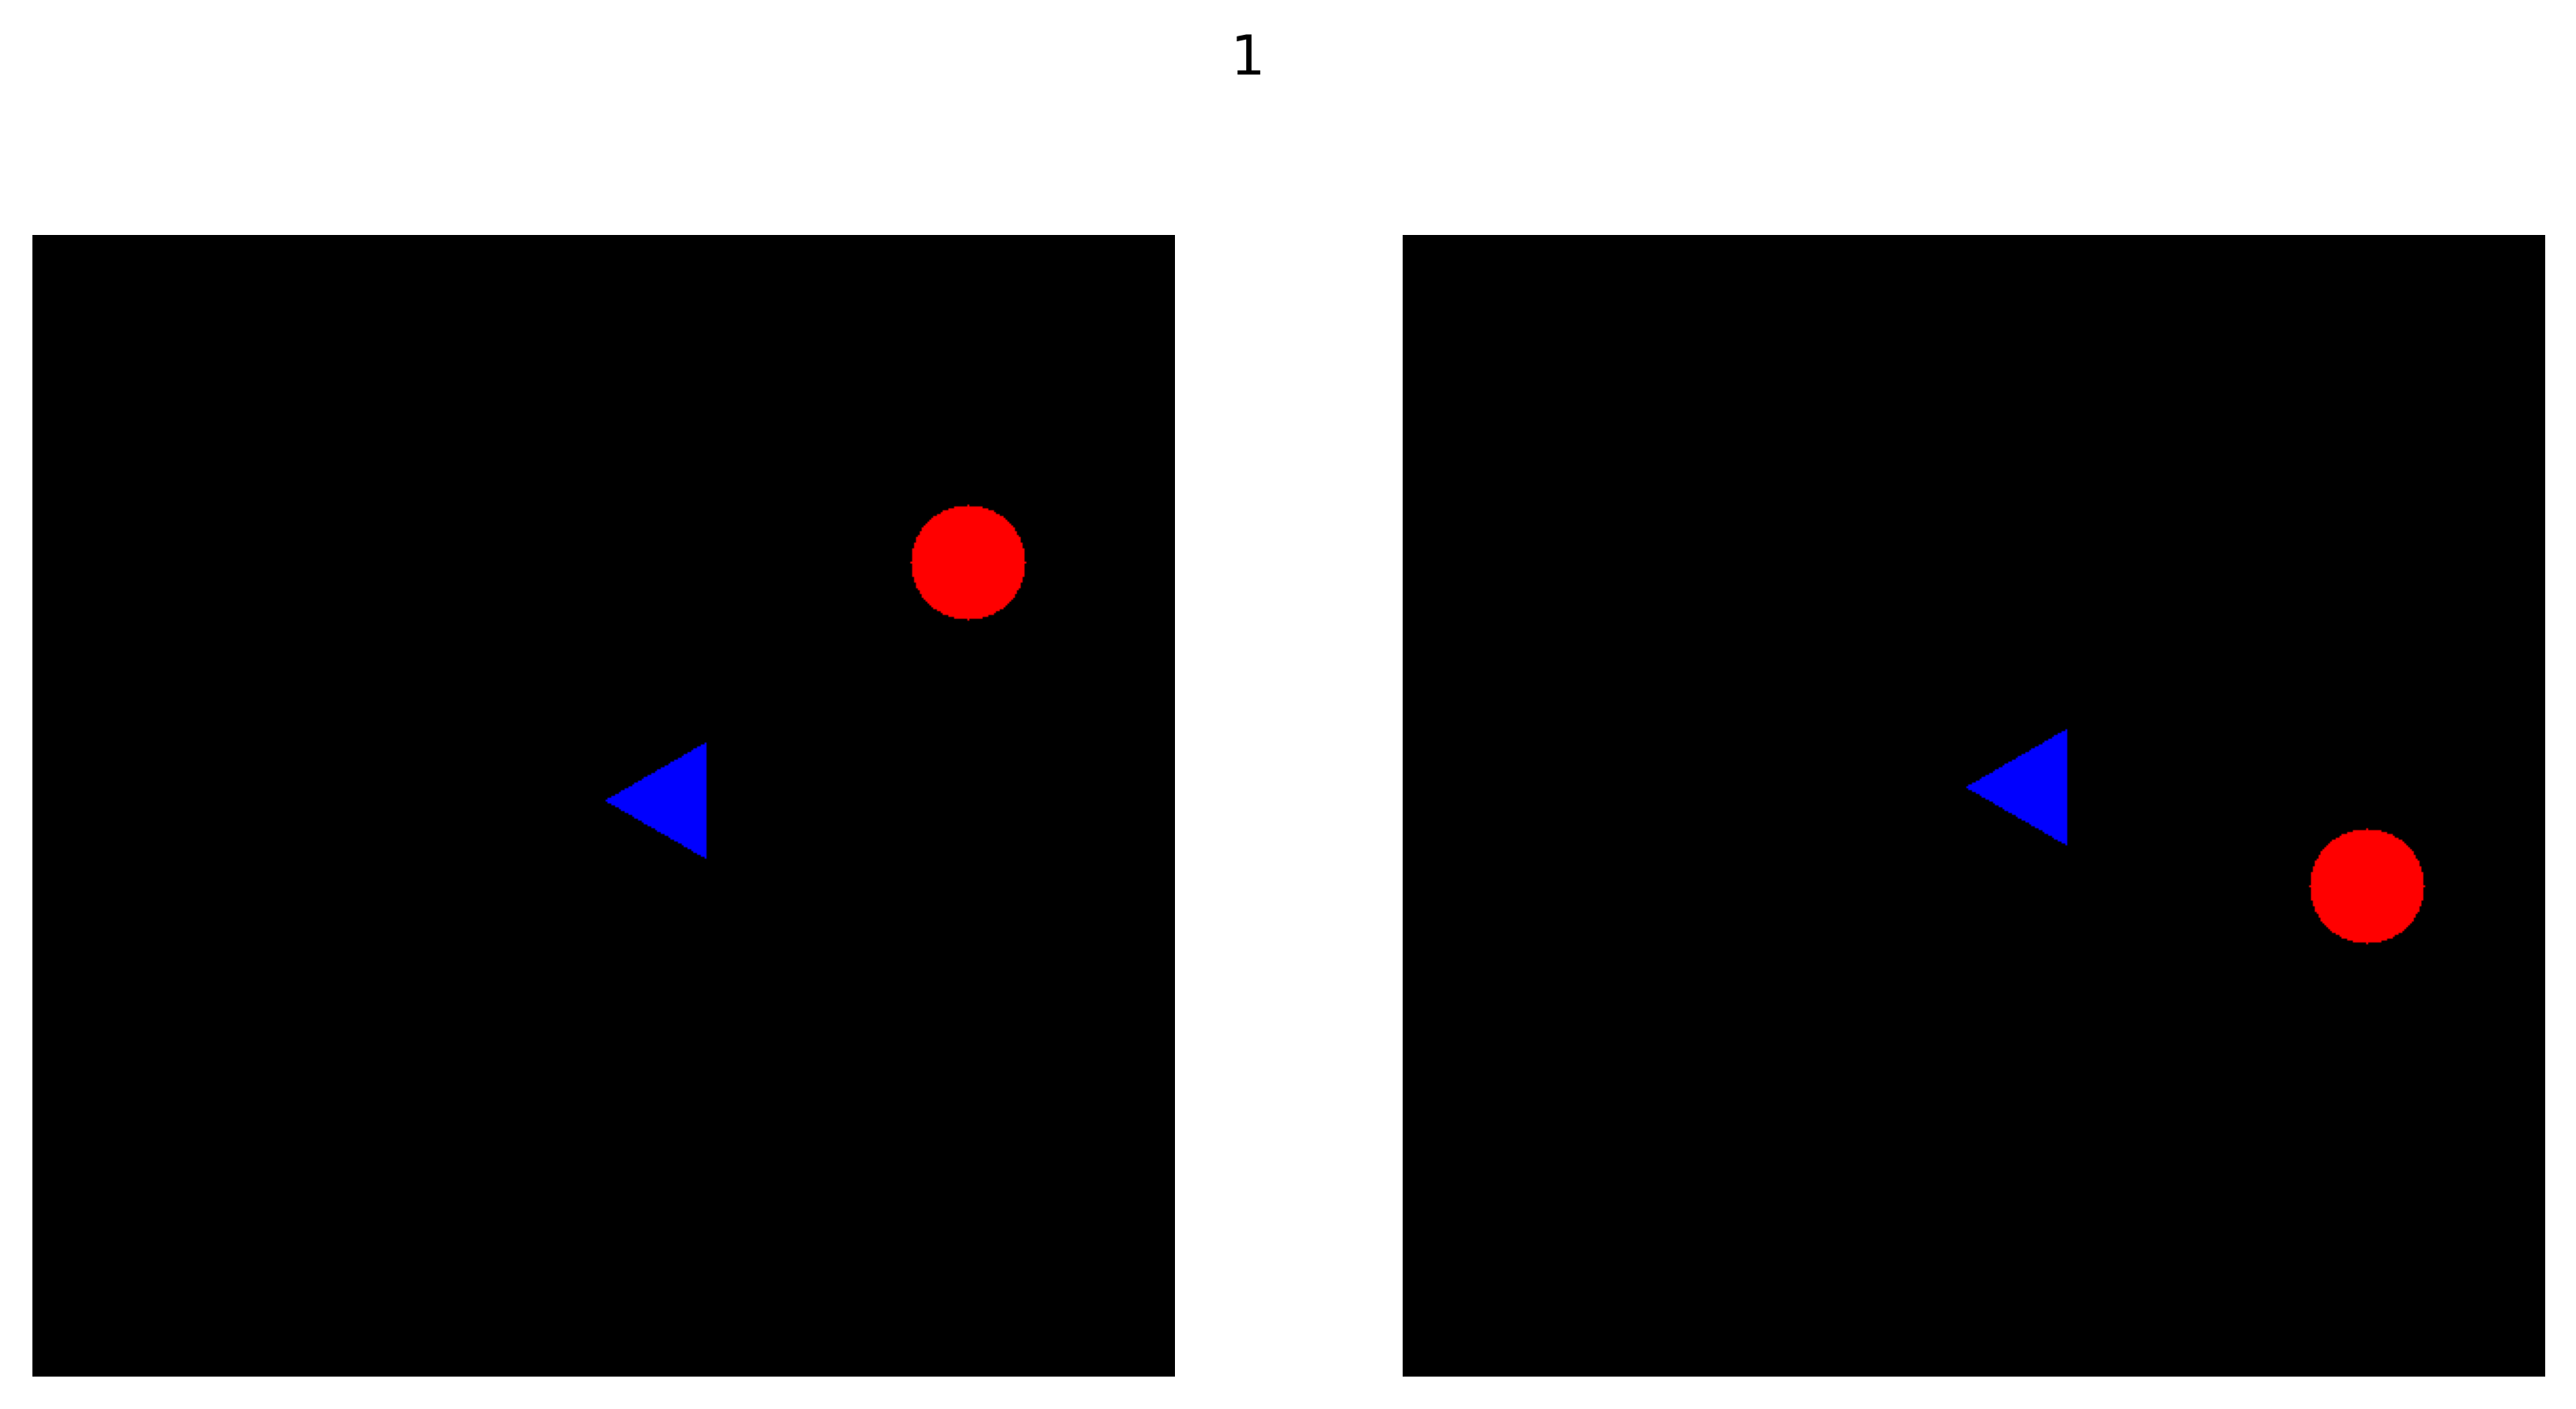

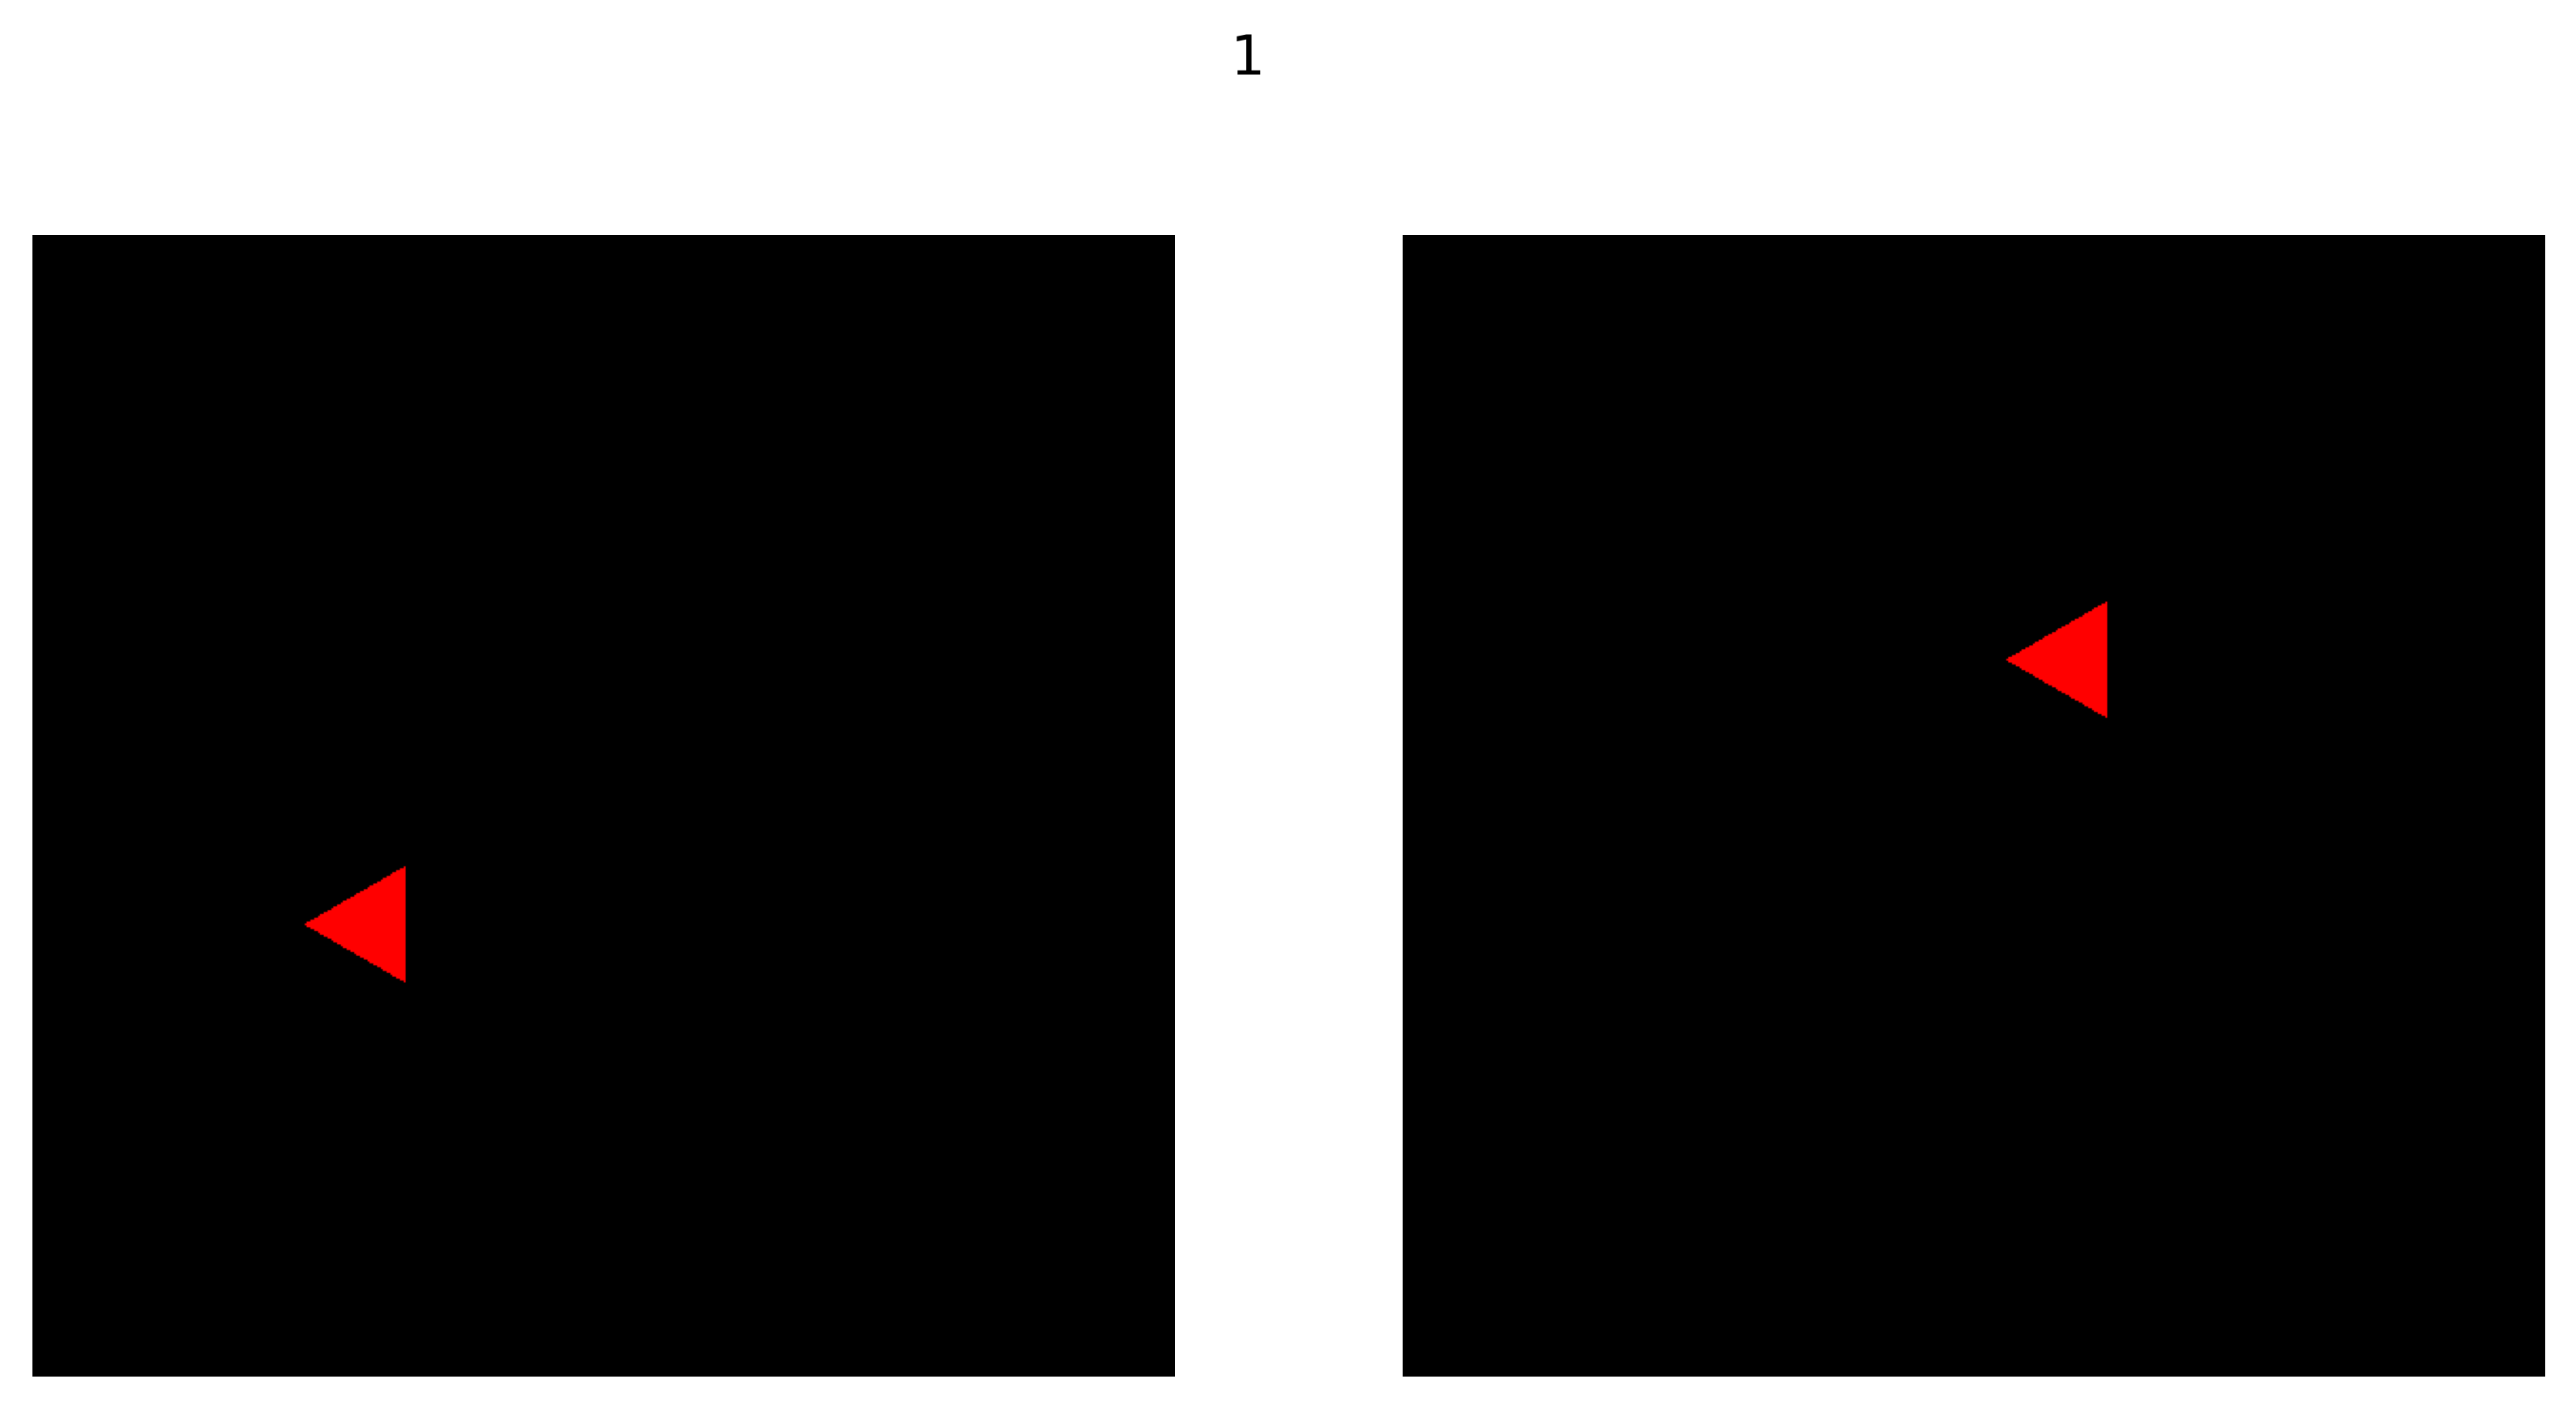

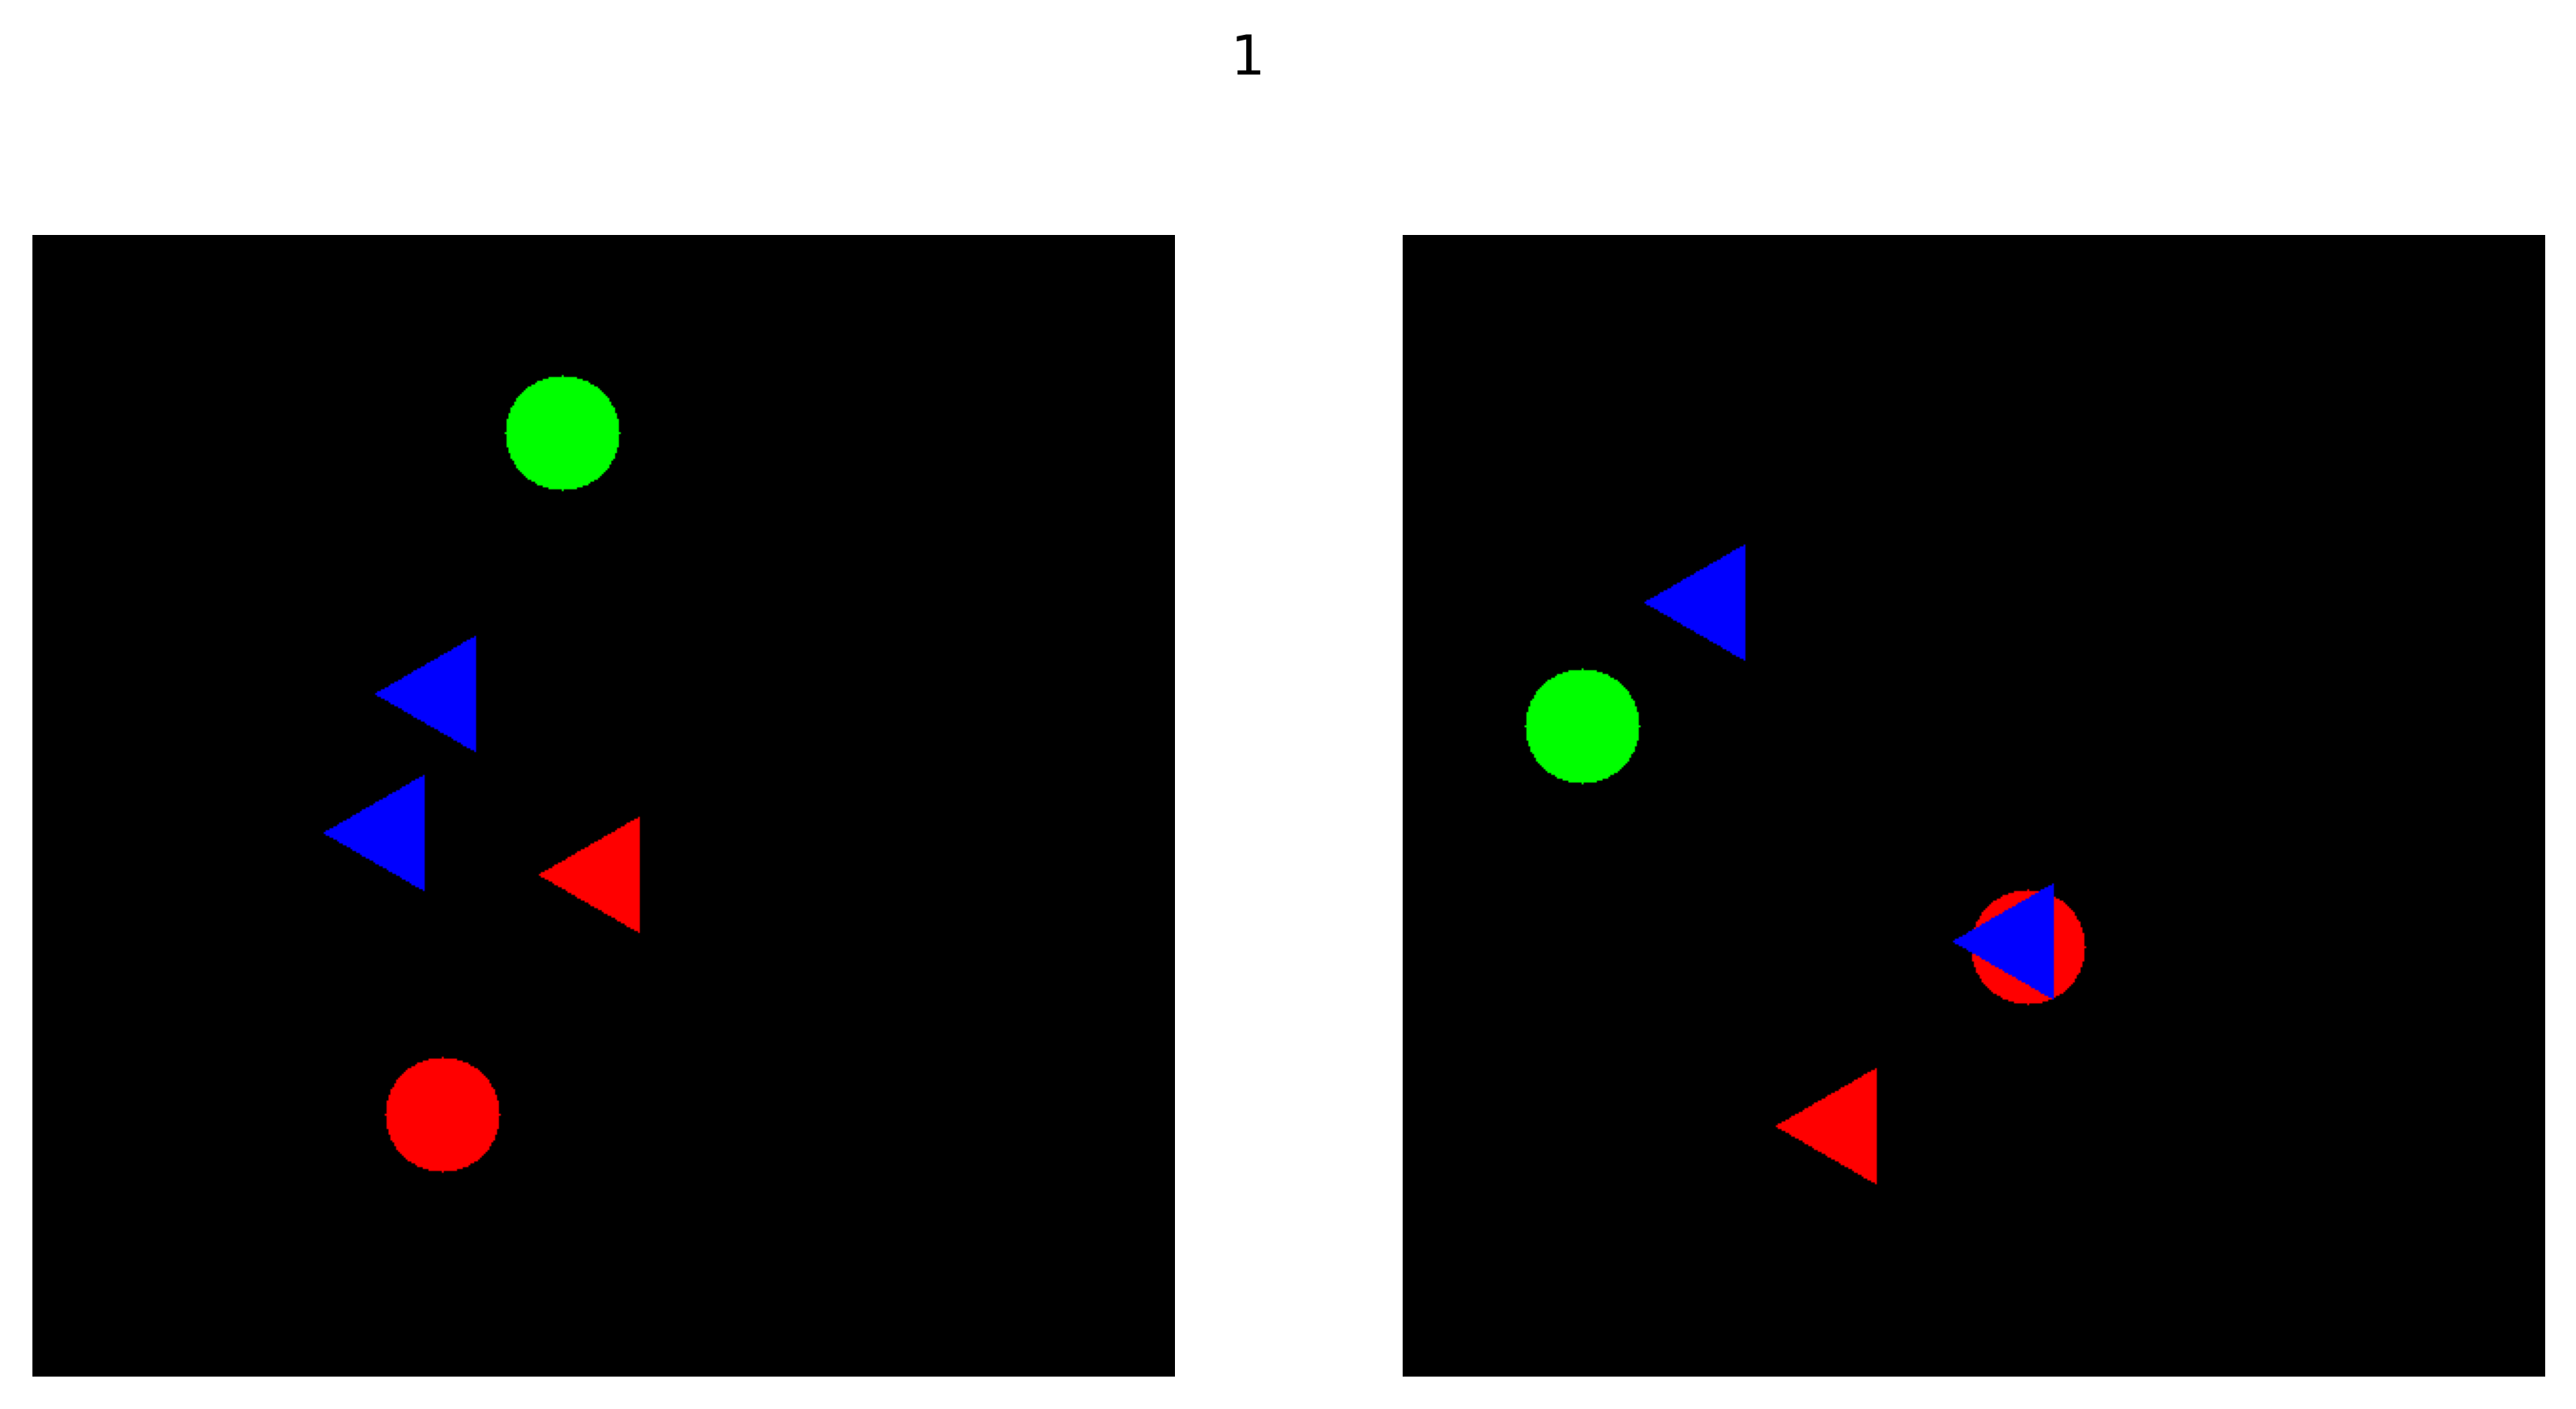

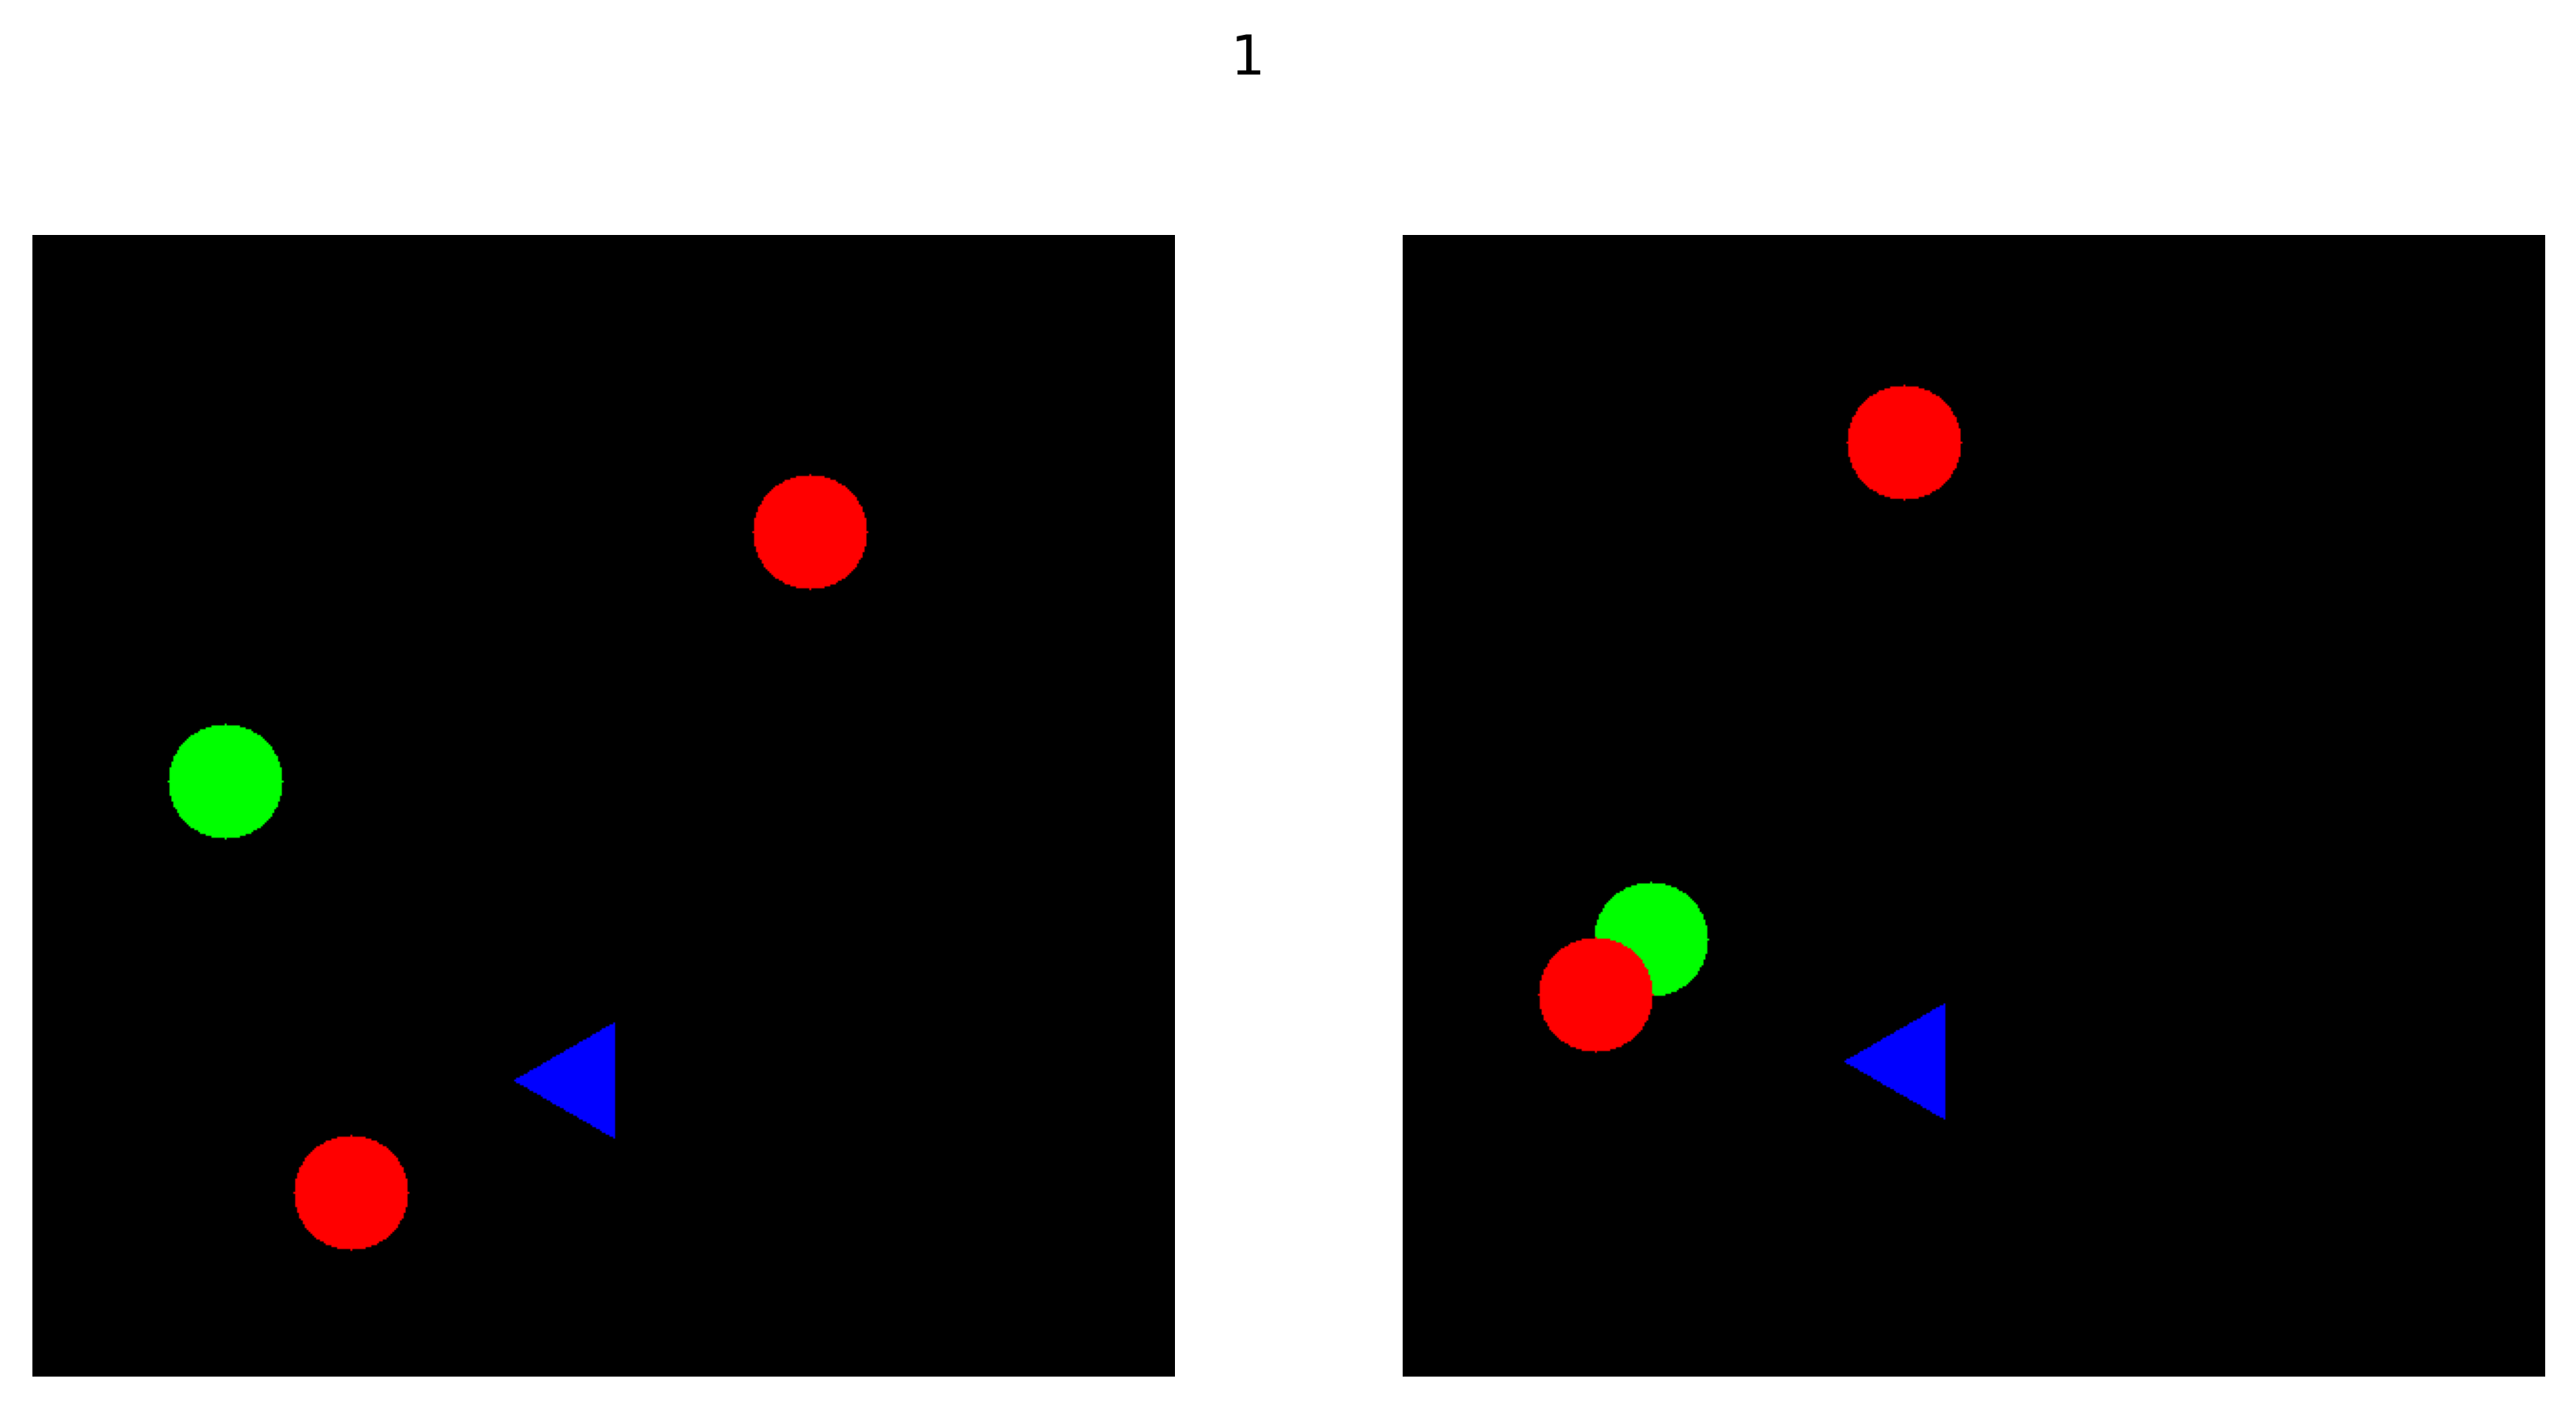

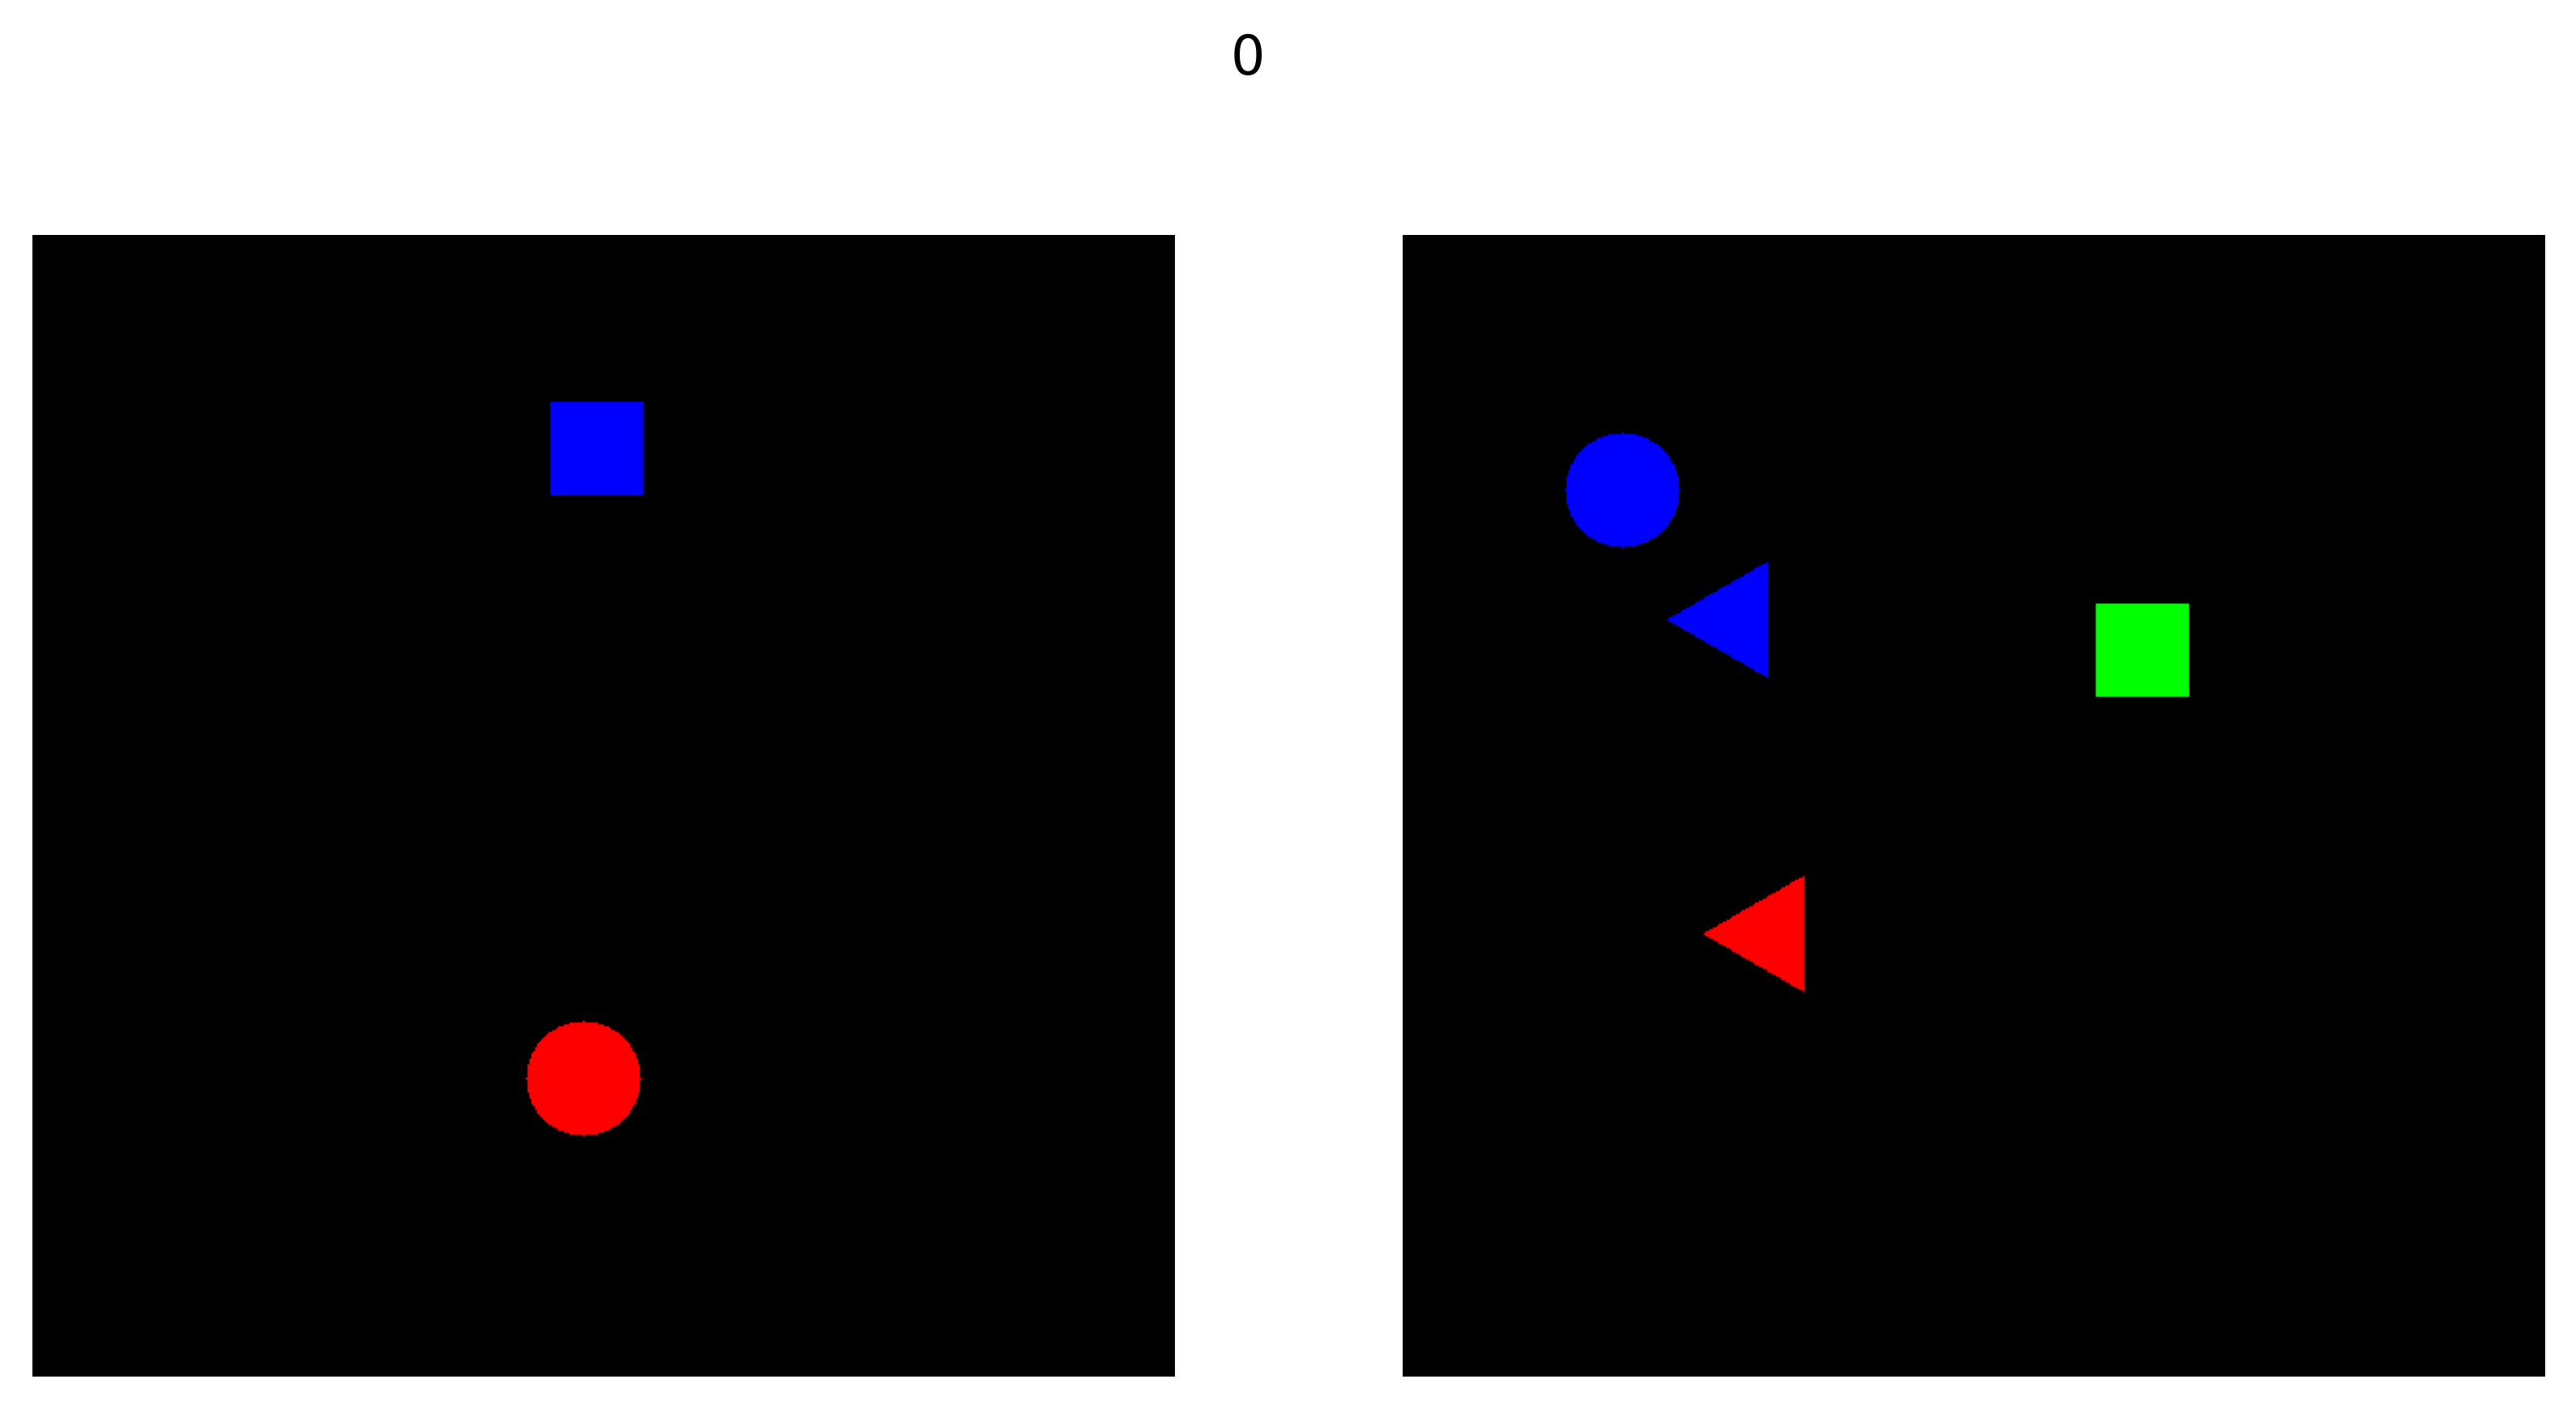

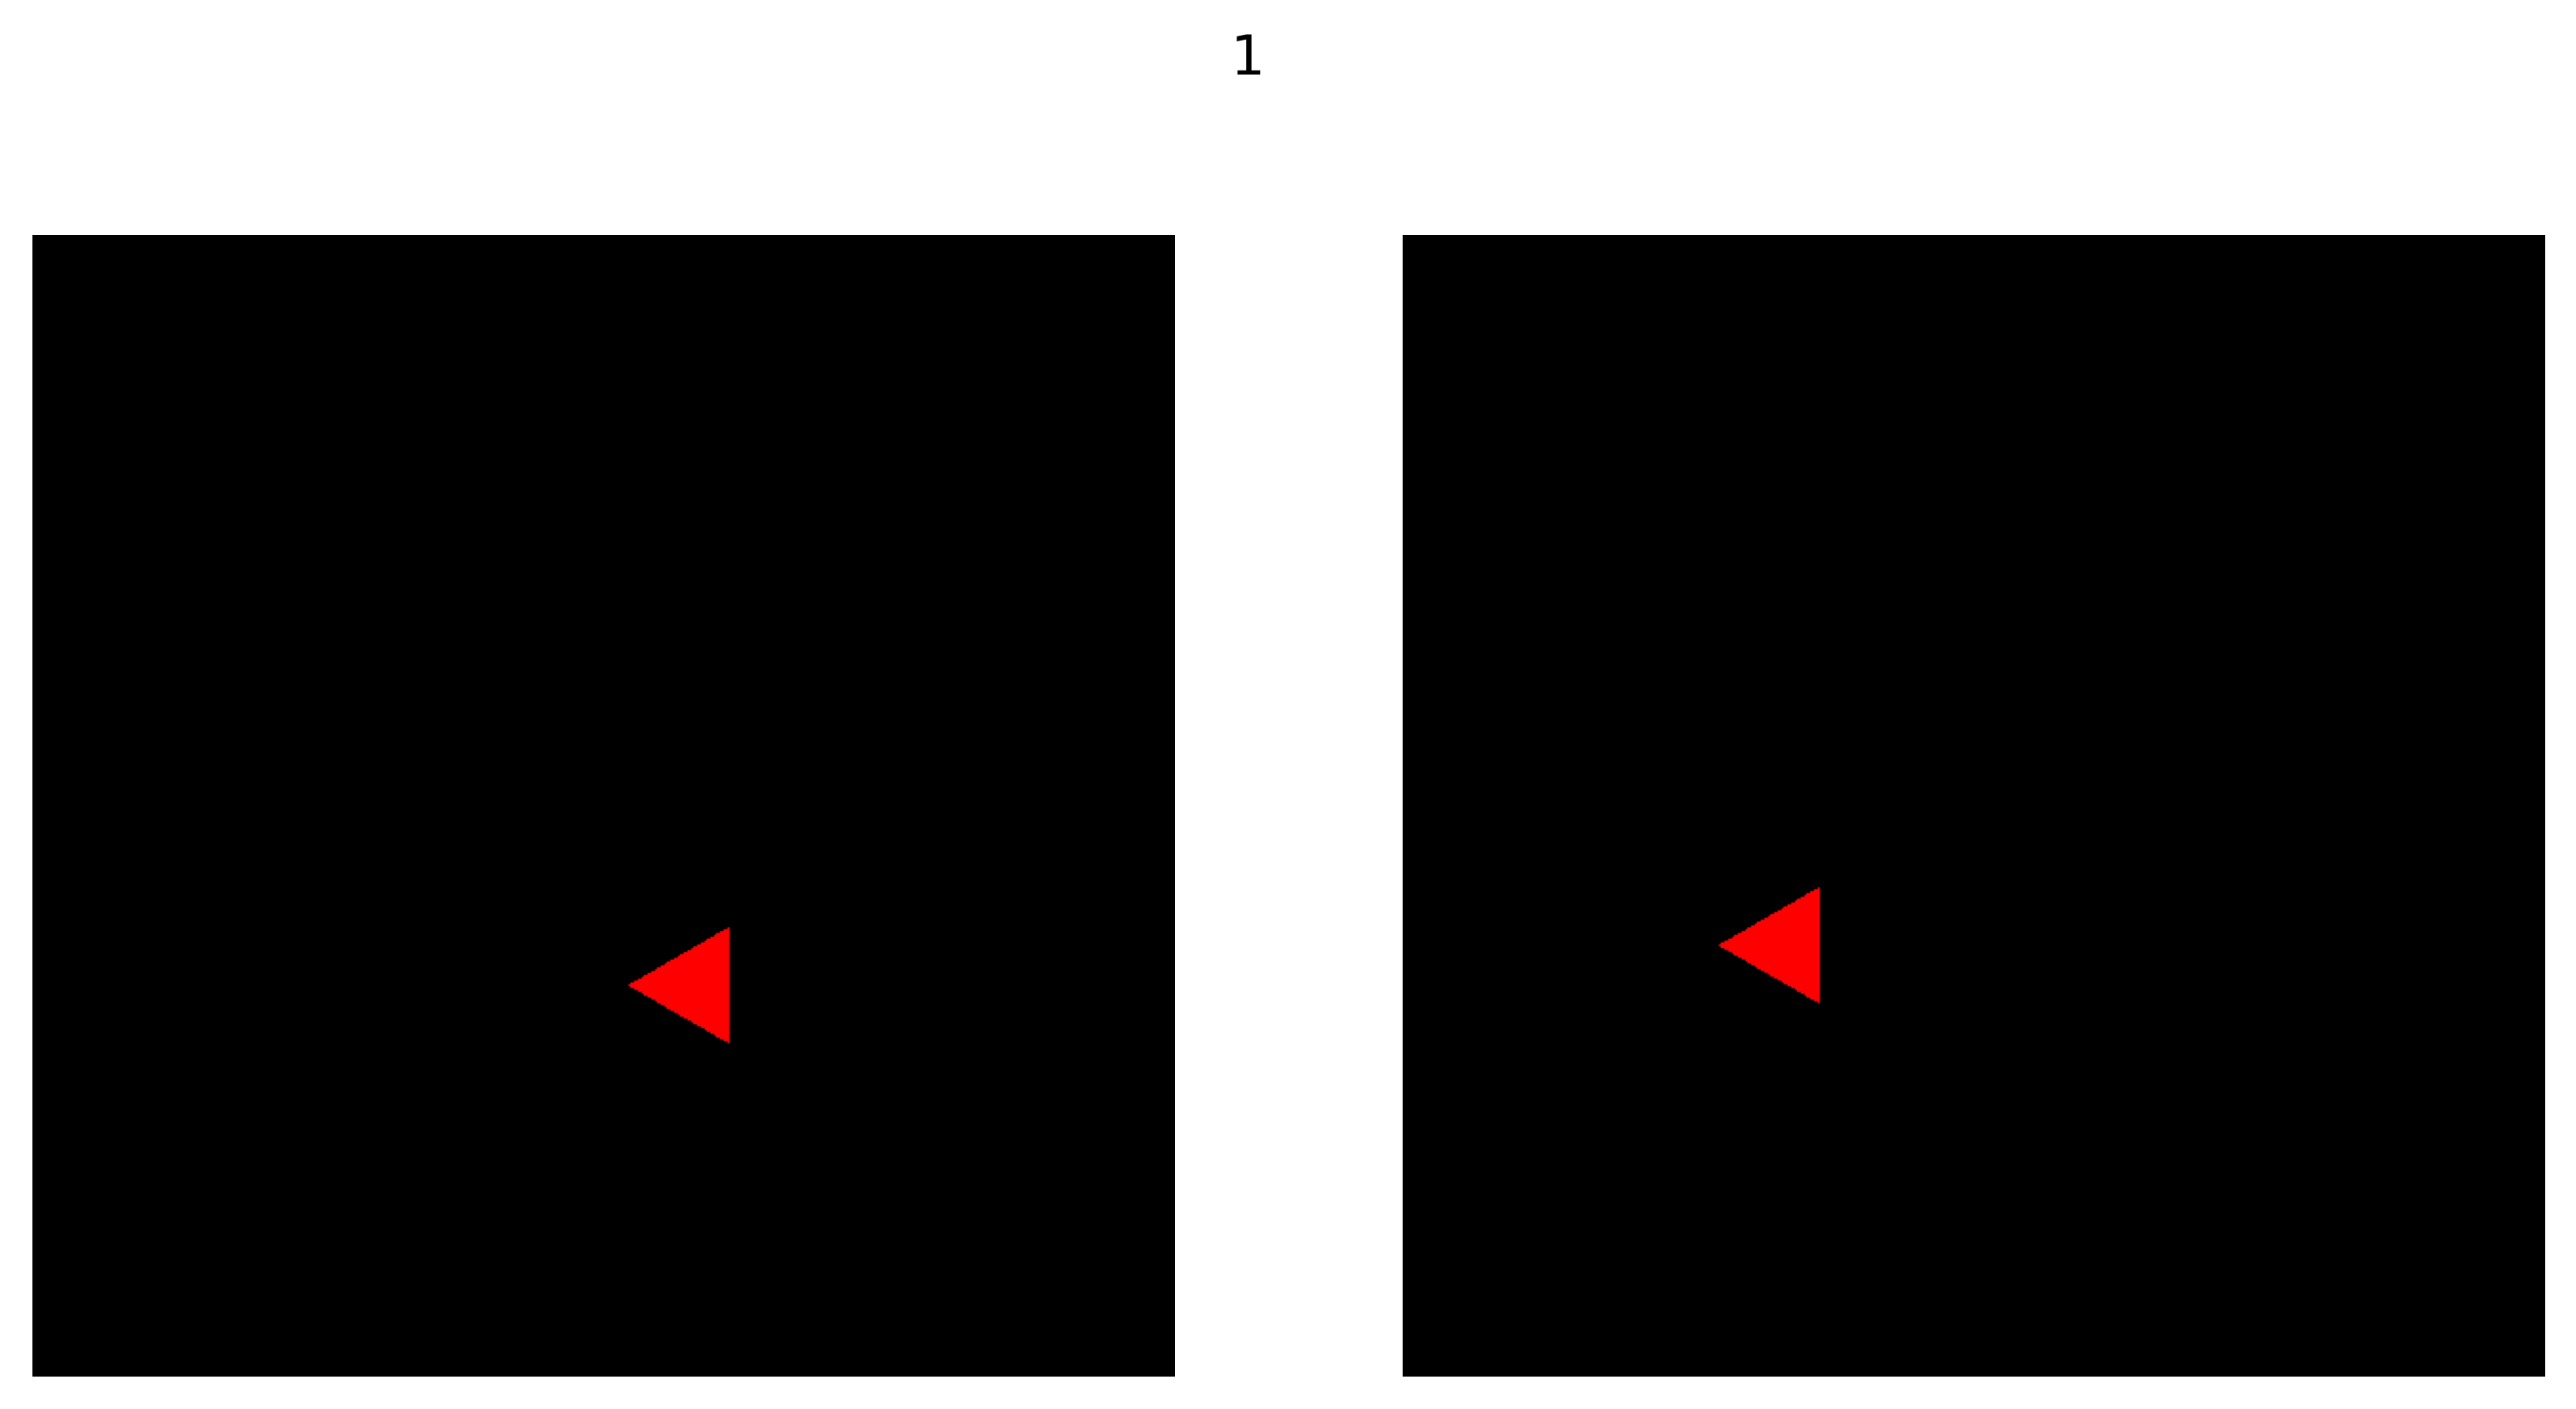

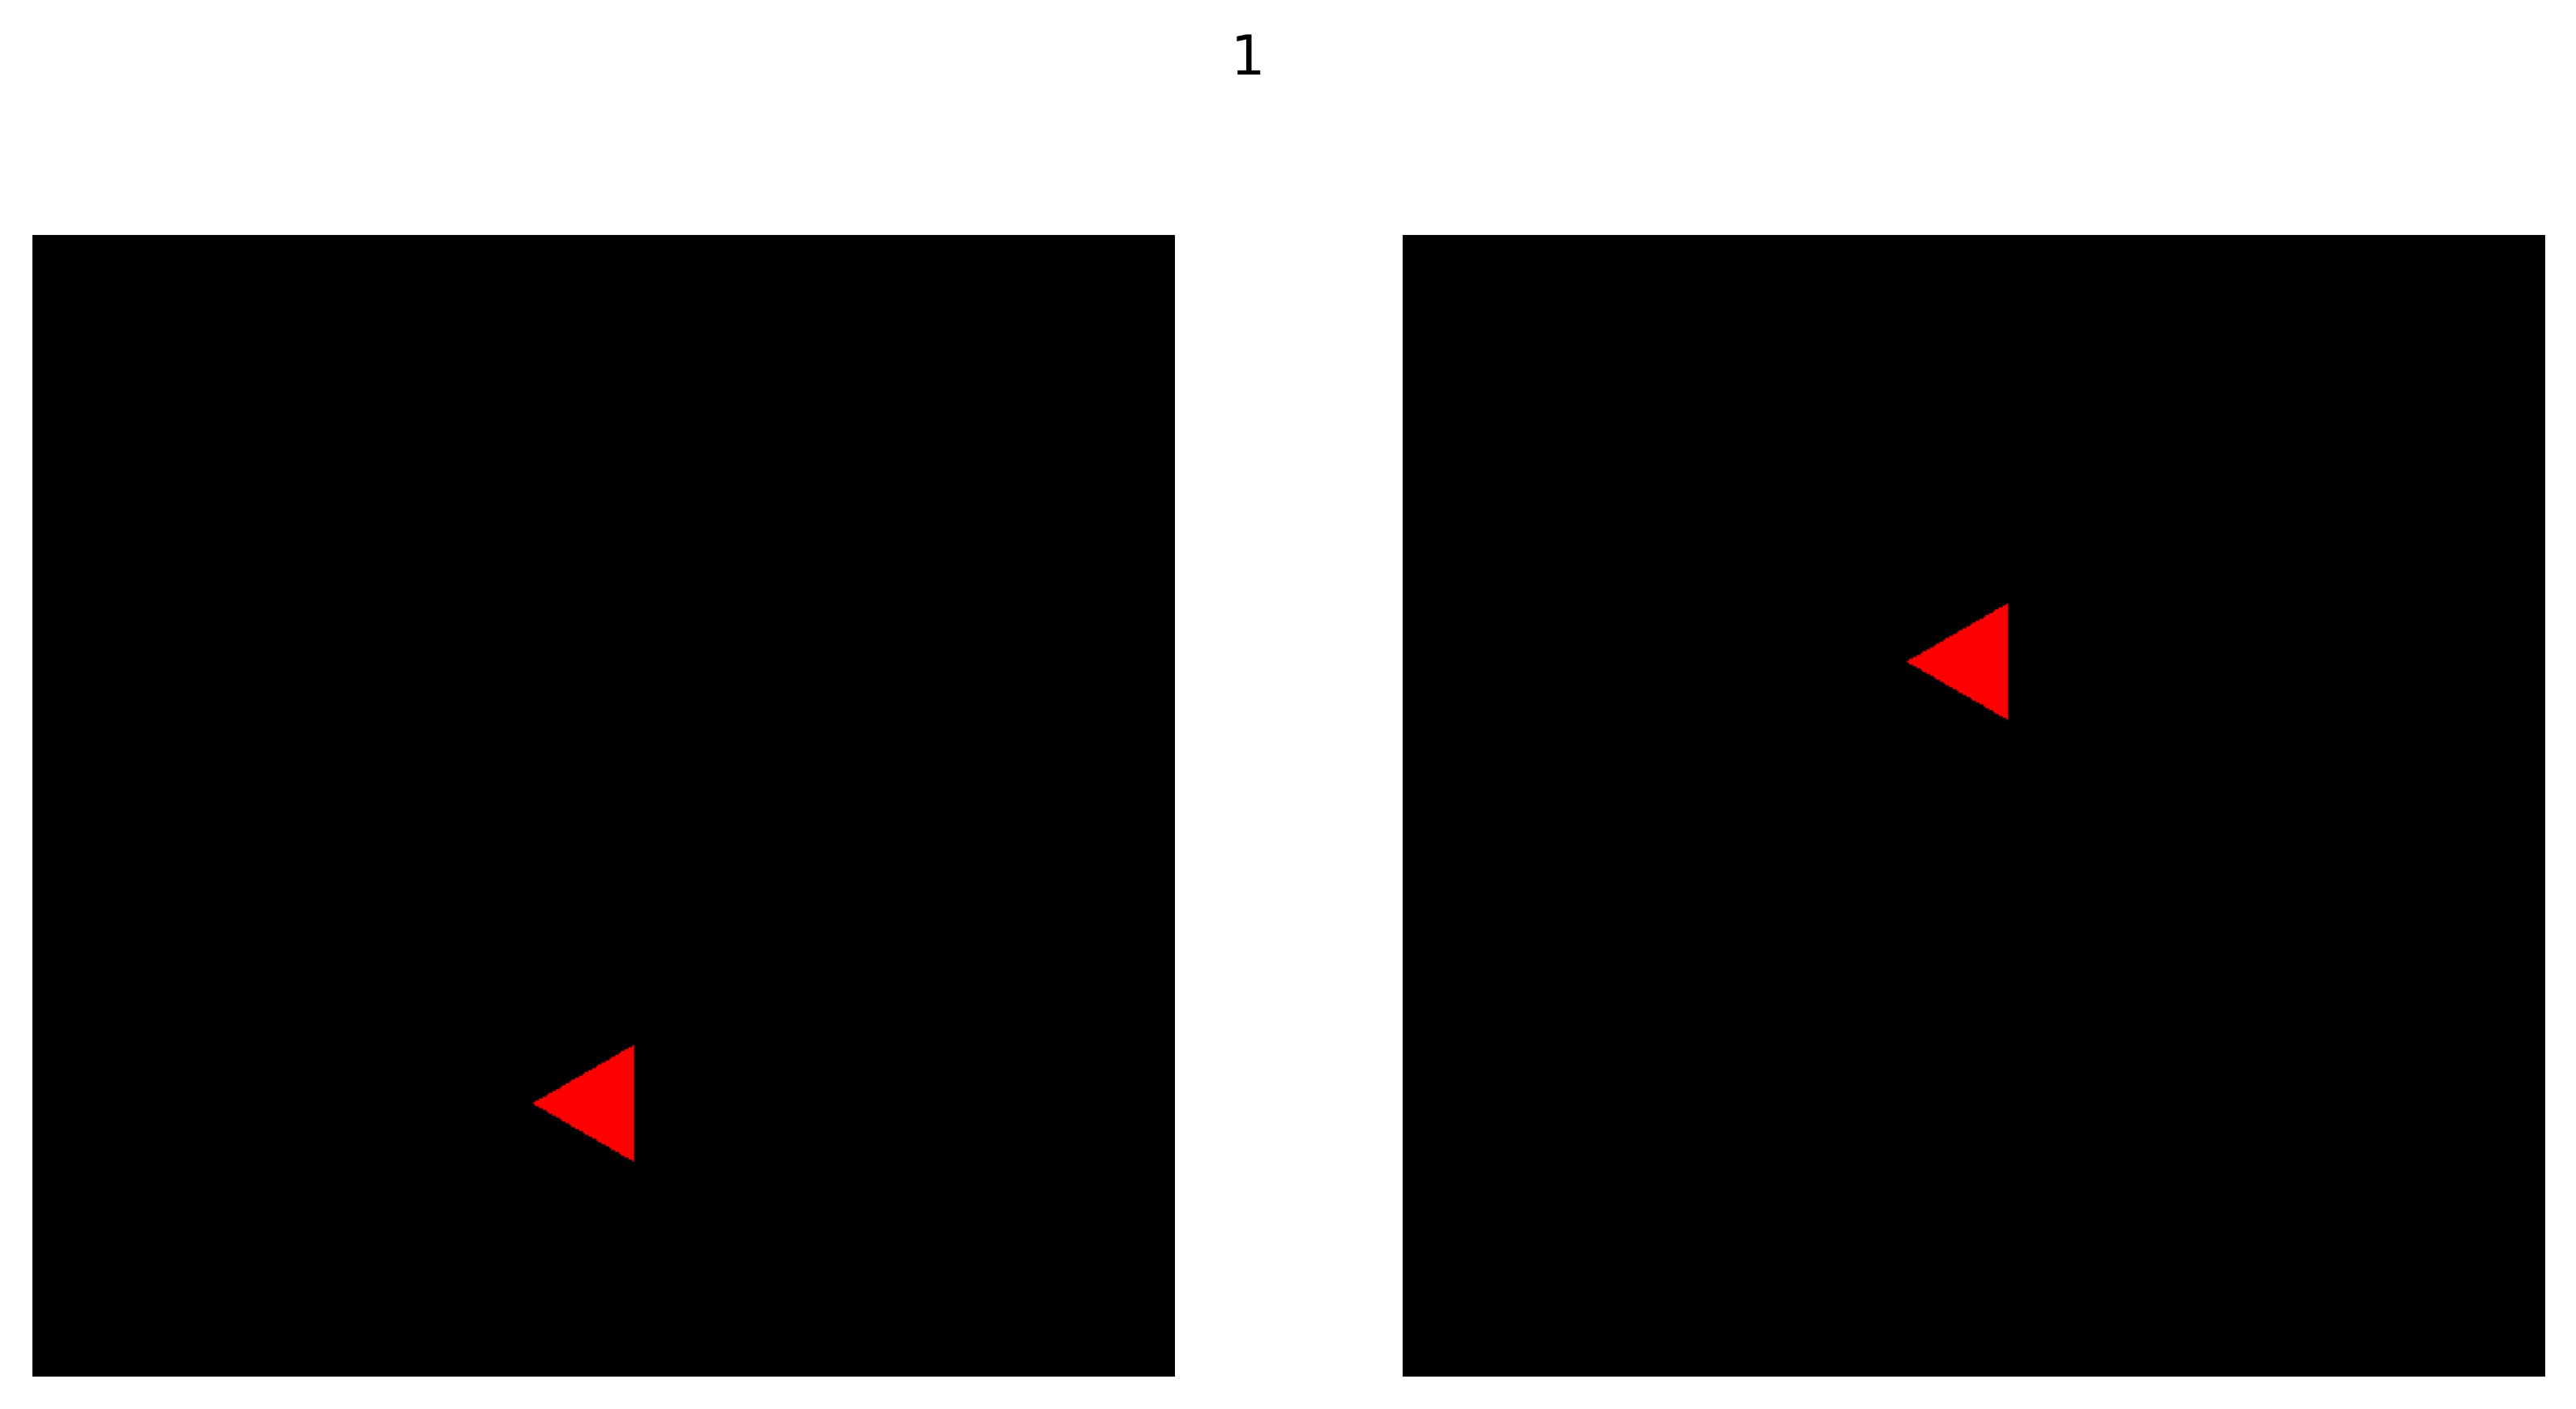

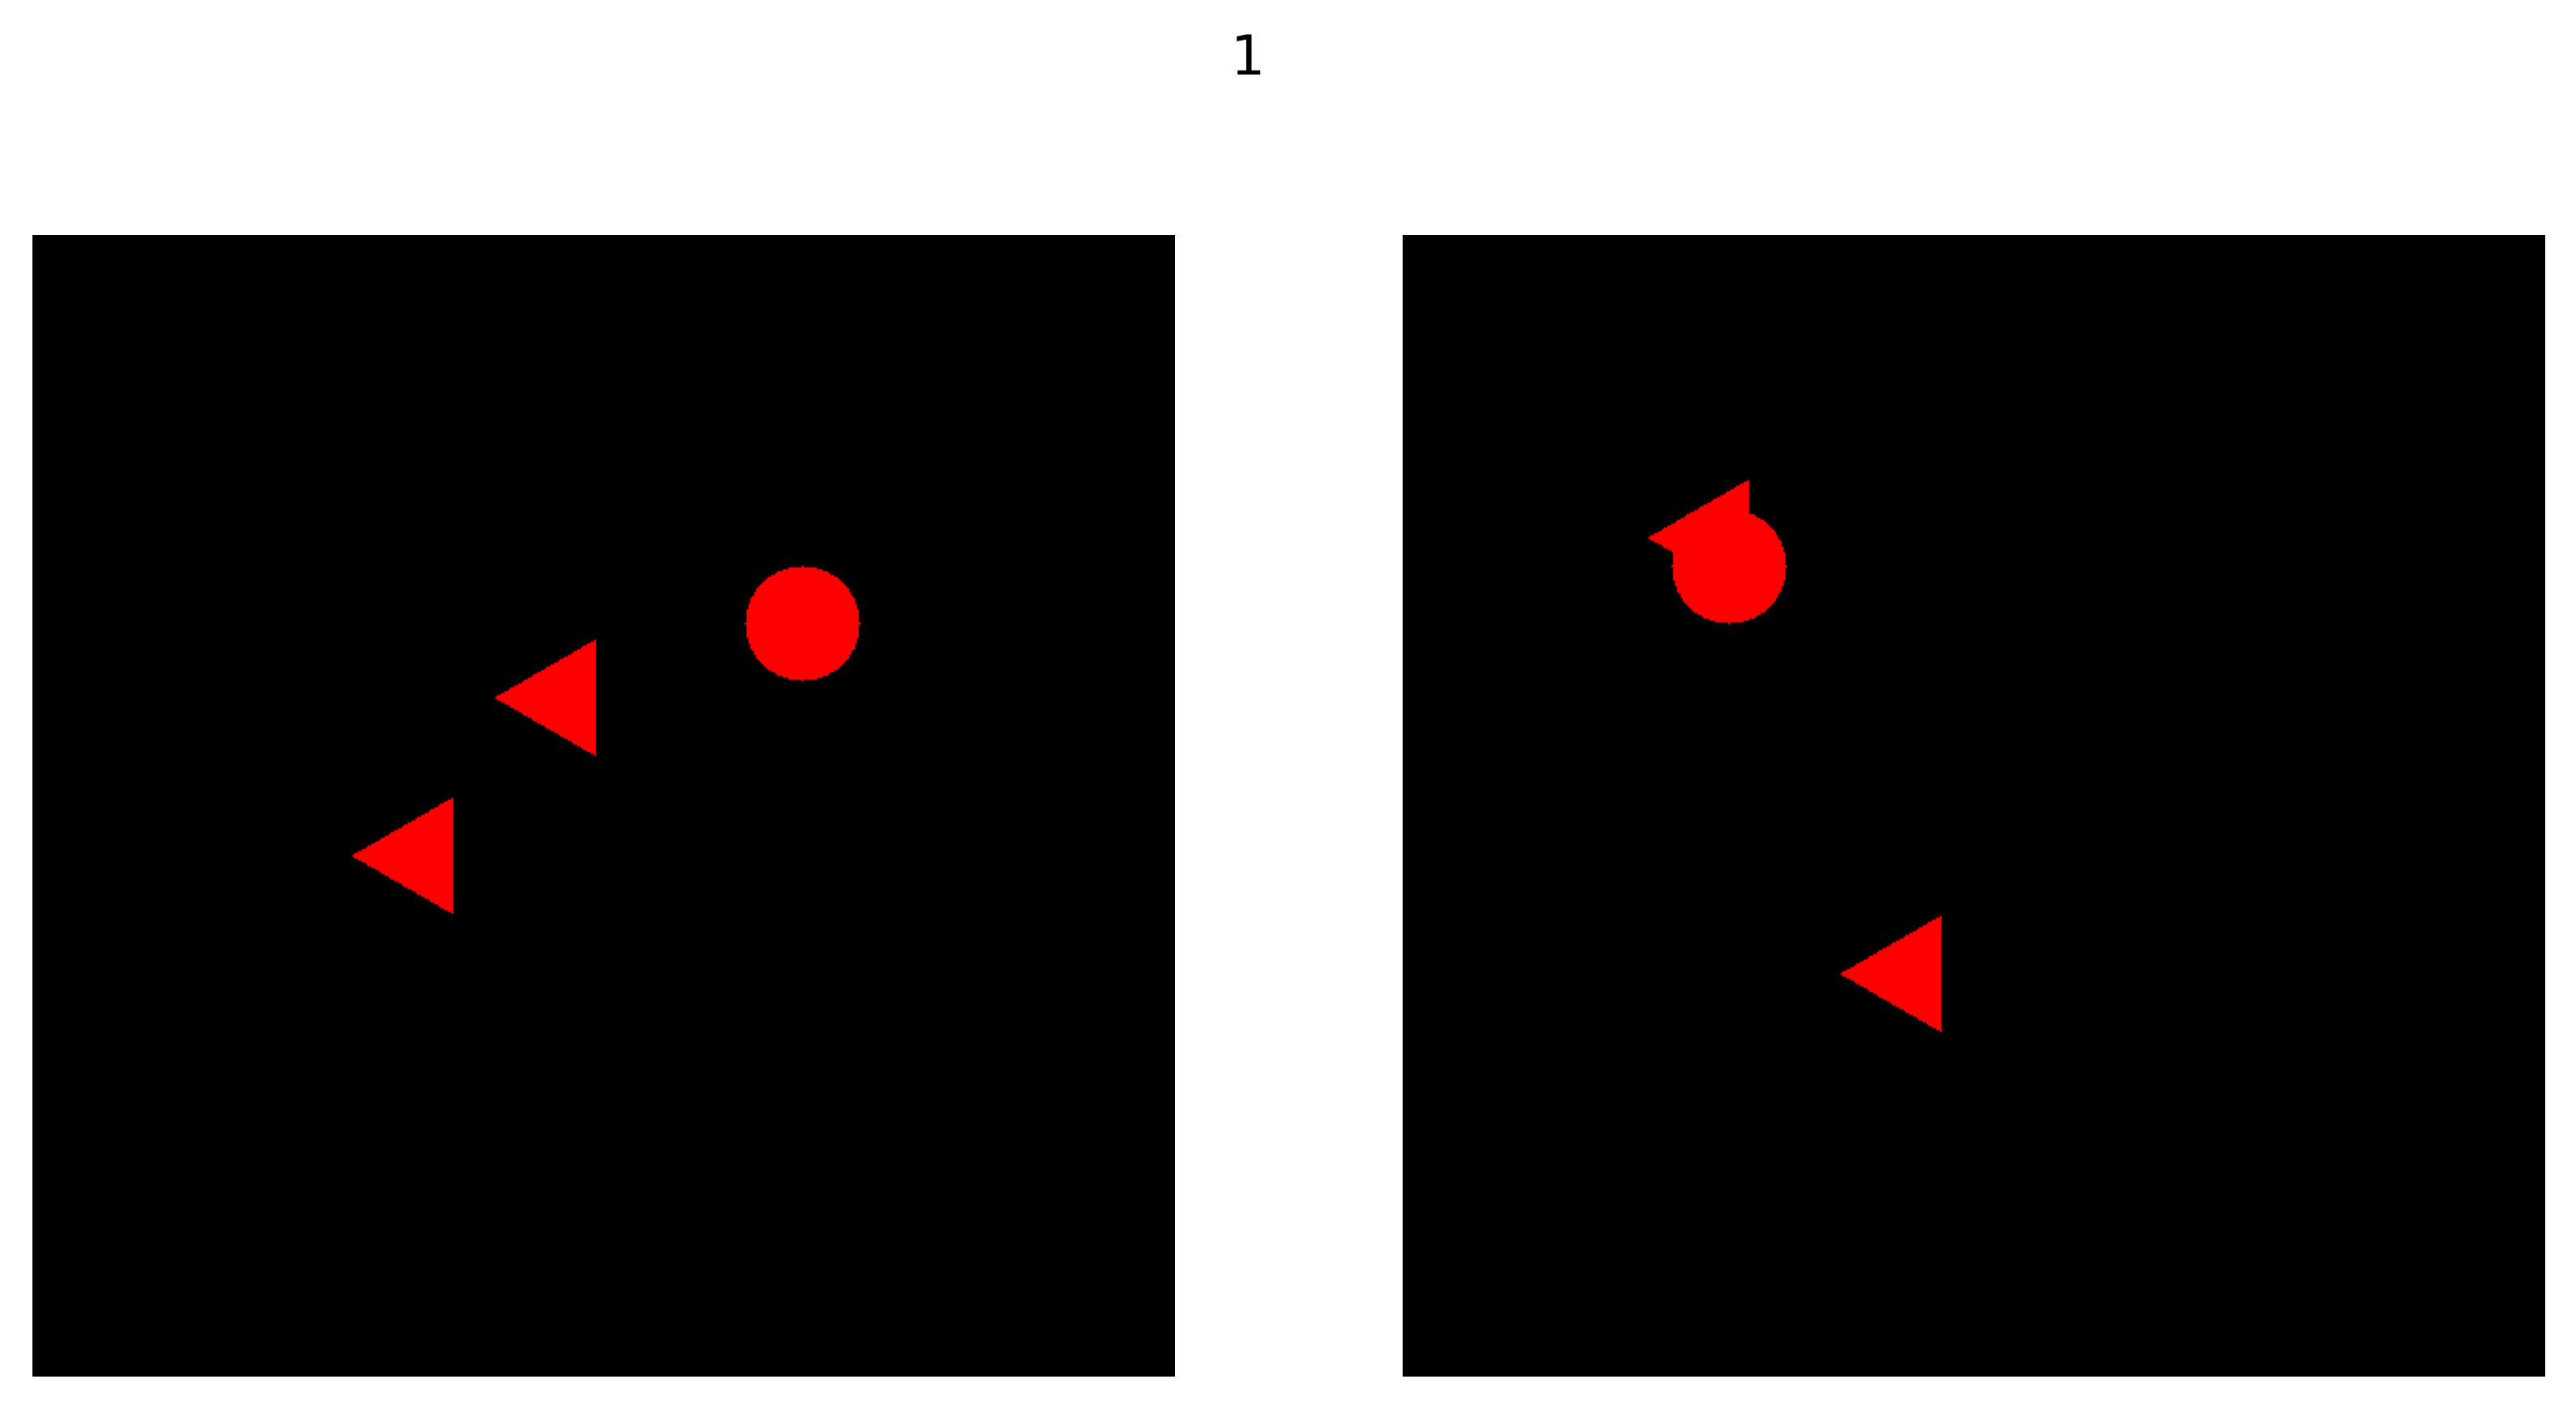

In [4]:
data = ShapeData(dim=600,
                 batch_size=8,
                 rotate=False,
                 padding=0.2)
show_off_dataset(data, 1, 8)